## pytorch 实现diffusion models
对于车的图像



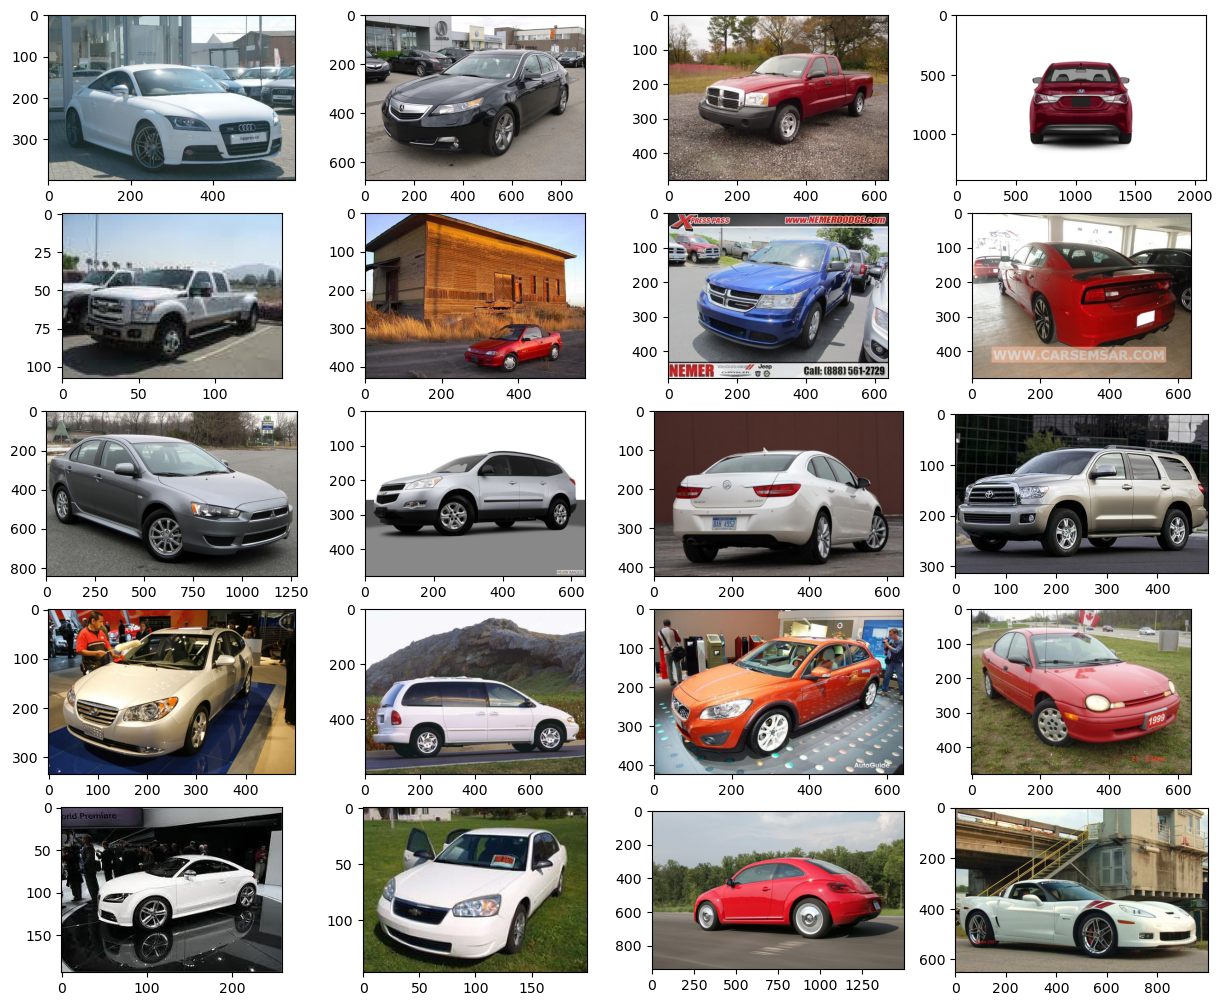

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols + 1), cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.StanfordCars(root=".", download=True)
show_images(data)

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect. 

# 搭建 Diffusion Model


## 第1步：正向过程=噪声调度器




我们首先需要为我们的模型构建输入，这些输入是越来越多的噪声图像。我们可以使用论文中提供的封闭形式来单独计算任何时间步长的图像，而不是按顺序执行此操作。

**详情点**:
- 可以预先计算噪声水平/方差

- 有不同类型的方差表

- 我们可以对每个时间步长的图像进行独立采样（高斯之和也是高斯的）

- 在这个前进步骤中不需要模型

In [5]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    返回所传递的值列表vals中的特定索引，同时考虑到批处理维度。
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device=device):
    """ 
    接收一个图像和一个时间步长作为输入，并 返回它的噪声版本
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    #均值+方差
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# 界定测试时间表
T = 300
betas = linear_beta_schedule(timesteps=T)

# 预先计算闭合形式的不同项
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

## 让我们在我们的数据集上测试一下......。

In [8]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

# 数据转换
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])

#tensor转化成图像
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    image = image.cpu().numpy()
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

C:\Users\86150\AppData\Local\Temp\ipykernel_19092\3062212951.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


AttributeError: 'numpy.ndarray' object has no attribute 'permute'

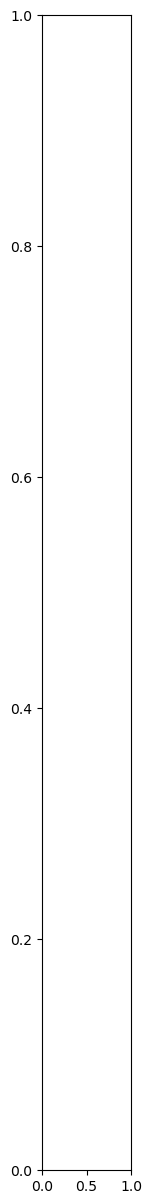

In [9]:
# 模拟正向扩散
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

## Step 2: 反向传播 = U-Net



U-Net教程: https://amaarora.github.io/2020/09/13/unet.html.


**详情点**:

-我们使用一种简单形式的 UNet 来预测图像中的噪声

-输入是噪声图像，输出图像中的噪声

-因为参数是跨时间共享的，所以我们需要告诉网络我们在哪个时间步长

-Timestep 由变压器 Sinusoidal Embedding 编码

-我们输出一个单一的值（均值），因为方差是固定的


In [ ]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # 第一次卷积
        h = self.bnorm1(self.relu(self.conv1(x)))
        # 时间嵌入
        time_emb = self.relu(self.time_mlp(t))
        # 扩展到最后2个维度
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # 添加时间通道
        h = h + time_emb
        # 第二次卷积
        h = self.bnorm2(self.relu(self.conv2(h)))
        # 上采样或者下采样
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    Unet架构的一个简化版本
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # 时间嵌入
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # 初始预估
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # 下采样
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # 上采样
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # 时间嵌入
        t = self.time_mlp(timestep)
        # 初始卷积
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # 添加残差结构作为额外的通道
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

## Step 3: 损失函数



In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## 采样
- 如果不加入@torch.no_grad()，我们很快就会耗尽内存，因为pytorch会把之前所有的图像都打包用于梯度计算
 
- 因为我们预先计算了前向通道的噪声方差，所以当我们依次执行后向过程时也必须使用这些方差

In [ ]:
@torch.no_grad()#防止内存爆炸
def sample_timestep(x, t):
    """
    调用模型来预测图像中的噪声，并返回 
    去噪后的图像。
    如果我们还没有进入最后一步，则对该图像施加噪声。
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # 调用模型（当前图像--噪声预测）。
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # 样本噪声
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize+1))
            show_tensor_image(img.detach().cpu())
    plt.show()            

## Training

Epoch 0 | step 000 Loss: 0.7540410757064819 


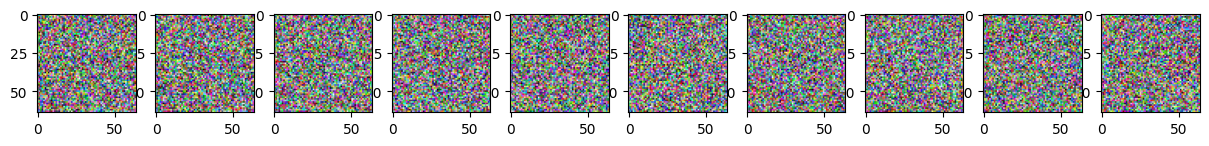

Epoch 5 | step 000 Loss: 0.16058993339538574 


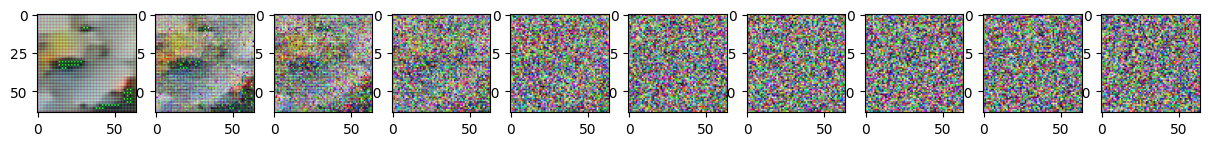

Epoch 10 | step 000 Loss: 0.15445035696029663 


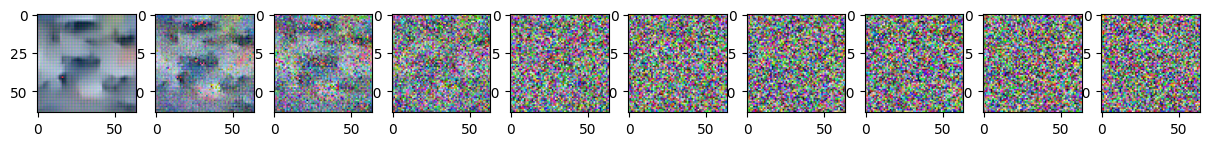

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()